### Enter FRED API key here to run notebook:

In [ ]:
fred_api = ************

In [1]:
import requests
import numpy as np
import pandas as pd
import json

from dateutil.parser import parse

import datetime

import yfinance as yf
from fredapi import Fred 

from bs4 import BeautifulSoup
import re

import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.utils import class_weight

import xgboost as xgb
from xgboost import XGBClassifier

import lightgbm as lgbm
from lightgbm import LGBMClassifier

import pickle

import plotly

import warnings
warnings.filterwarnings("ignore")

fred = Fred(api_key=f'{fred_api}')

In [2]:
all_data = pd.read_csv('all_data_max_daily.csv')
all_data['model_date'] = pd.to_datetime(all_data['model_date'])  # convert to datetime type
all_data = all_data.set_index('model_date')                      # set model_date as index
all_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35191 entries, 1927-12-30 to 2024-05-04
Data columns (total 60 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   AE                    8887 non-null   float64
 1   ASPUS                 22286 non-null  float64
 2   BAMLC0A0CM            9987 non-null   float64
 3   BAMLEMCBPIOAS         9257 non-null   float64
 4   BAMLEMRACRPIASIAOAS   9257 non-null   float64
 5   BAMLH0A0HYM2          9987 non-null   float64
 6   BAMLH0A0HYM2EY        9987 non-null   float64
 7   BAMLHE00EHYIOAS       9622 non-null   float64
 8   CIVPART               27844 non-null  float64
 9   CORESTICKM159SFRBATL  20566 non-null  float64
 10  CPIAUCSL              28205 non-null  float64
 11  CPILFESL              24552 non-null  float64
 12  CSUSHPINSA            17931 non-null  float64
 13  Credit                8887 non-null   float64
 14  DAAA                  15098 non-null  float64
 15  DF

In [3]:
# I want my model on a weekly timeframe so I will use Friday values only
# Remember that in my data collection phase, if a Friday is a holiday it will contain Thursday's observations

friday_data = all_data[all_data.index.day_name()=='Friday']


# To show where DGS2 becomes available
friday_data.loc['1976-05-01':'1976-06-30']['DGS2']

model_date
1976-05-07     NaN
1976-05-14     NaN
1976-05-21     NaN
1976-05-28     NaN
1976-06-04    7.12
1976-06-11    7.03
1976-06-18    6.99
1976-06-25    7.02
Name: DGS2, dtype: float64

In [4]:
# I want to see data from June 1976 

friday_1976=friday_data.loc['1976-06-01':]
friday_1976 = friday_1976.dropna(axis='columns') # drop any columns that start after June 1976
friday_1976.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2501 entries, 1976-06-04 to 2024-05-03
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ASPUS                 2501 non-null   float64
 1   CIVPART               2501 non-null   float64
 2   CORESTICKM159SFRBATL  2501 non-null   float64
 3   CPIAUCSL              2501 non-null   float64
 4   CPILFESL              2501 non-null   float64
 5   CSUSHPINSA            2501 non-null   float64
 6   DFF                   2501 non-null   float64
 7   DGS10                 2501 non-null   float64
 8   DGS2                  2501 non-null   float64
 9   DGS20                 2501 non-null   float64
 10  DGS3                  2501 non-null   float64
 11  DGS5                  2501 non-null   float64
 12  DGS7                  2501 non-null   float64
 13  DTB3                  2501 non-null   float64
 14  GDP                   2501 non-null   float64
 15  GDP

In [5]:
# Function to create some new columns, including the 13W (3-month) shift columns

def my_new_features(df):
    
    df['TermSpread'] = df['DGS10'] - df['DGS2'] # new feature I believe may be important

    df['DGS10_13WShift'] = df['DGS10'].shift(-13)
    df['^GSPC_13WShift'] = df['^GSPC'].shift(-13)

    df['DGS10_13WChange'] = df['DGS10_13WShift'] - df['DGS10']
    df['^GSPC_13WChange'] = ( (df['^GSPC_13WShift'] / df['^GSPC']) - 1 ) * 100

In [6]:
my_new_features(friday_1976) # apply function to friday_1976 dataframe
friday_1976.tail()

,ASPUS,CIVPART,CORESTICKM159SFRBATL,CPIAUCSL,CPILFESL,CSUSHPINSA,DFF,DGS10,DGS2,DGS20,...,PAYEMS,PCE,PSAVERT,UNRATE,^GSPC,TermSpread,DGS10_13WShift,^GSPC_13WShift,DGS10_13WChange,^GSPC_13WChange
model_date,,,,,,,,,,,,,,,,,,,,,
2024-04-05,492300.0,62.7,4.403102,311.054,315.565,310.455,5.33,4.39,4.73,4.65,...,158133.0,19189.0,3.6,3.8,5204.339844,-0.34,NaN,NaN,NaN,NaN
2024-04-12,492300.0,62.7,4.509212,312.230,316.698,310.455,5.33,4.50,4.88,4.73,...,158133.0,19189.0,3.6,3.8,5123.410156,-0.38,NaN,NaN,NaN,NaN
2024-04-19,492300.0,62.7,4.509212,312.230,316.698,310.455,5.33,4.62,4.97,4.83,...,158133.0,19189.0,3.6,3.8,4967.229980,-0.35,NaN,NaN,NaN,NaN
2024-04-26,492300.0,62.7,4.509212,312.230,316.698,310.455,5.33,4.67,4.96,4.89,...,158133.0,19350.9,3.2,3.8,5099.959961,-0.29,NaN,NaN,NaN,NaN
2024-05-03,492300.0,62.7,4.509212,312.230,316.698,312.179,5.33,4.58,4.87,4.82,...,158286.0,19350.9,3.2,3.9,5127.790039,-0.29,NaN,NaN,NaN,NaN


In [7]:
# Change to percentage:
# ASPUS (Avg sales price home)
# CPIAUCSL (index)
# CPILFESL (index)
# CSUSHPINSA (home index)
# GDP (billions dollars)
# GDPC1 (billions 2017 dollars)
# GFDEBTN (millions dollars debt)
# ICSA (number of claims)
# M1SL (billions dollars)
# M2SL (billions dollars)
# MSPUS (Median sales price home)
# PAYEMS (number employees)
# PCE (billions dollars)
# ^GSPC (index)

In [8]:
percentage_list = ['ASPUS','CPIAUCSL','CPILFESL','CSUSHPINSA','GDP','GDPC1','GFDEBTN','ICSA','M1SL','M2SL','MSPUS',
                  'PAYEMS','PCE','^GSPC']

for series in percentage_list:
    new_name = series + '_pc'
    friday_1976[new_name] = (friday_1976[series] / friday_1976[series].shift(13) - 1 ) *100

In [9]:
friday_1976['1977-09-20':'1978-05-30'][['GDP','GDP_pc']]

,GDP,GDP_pc
model_date,,
1977-09-23,1952.9,3.783813
1977-09-30,1952.9,3.783813
1977-10-07,1952.9,3.783813
1977-10-14,1952.9,3.783813
1977-10-21,1952.9,3.783813
1977-10-28,1952.9,3.783813
1977-11-04,2015.1,3.185007
1977-11-11,2015.1,3.185007
1977-11-18,2015.1,3.185007


In [10]:
friday_1976.describe()

,ASPUS,CIVPART,CORESTICKM159SFRBATL,CPIAUCSL,CPILFESL,CSUSHPINSA,DFF,DGS10,DGS2,DGS20,...,GDP_pc,GDPC1_pc,GFDEBTN_pc,ICSA_pc,M1SL_pc,M2SL_pc,MSPUS_pc,PAYEMS_pc,PCE_pc,^GSPC_pc
count,2501.000000,2501.000000,2501.000000,2501.000000,2501.000000,2501.000000,2501.000000,2501.000000,2501.000000,2501.000000,...,2488.000000,2488.000000,2488.000000,2488.000000,2488.000000,2488.000000,2488.000000,2488.000000,2488.000000,2488.000000
mean,223734.266293,64.781887,4.039032,216.441661,177.702423,121.458991,4.642763,5.872171,5.002235,6.130948,...,1.476566,1.036712,2.146398,7.128711,2.612835,1.567342,1.238823,0.368759,1.531438,2.347511
std,121348.409455,1.746770,2.614039,58.594168,65.824338,69.238608,4.000450,3.294676,3.732952,3.036053,...,1.407023,2.708657,1.710793,125.823962,13.546315,1.419152,3.108469,1.105279,1.711824,7.500148
min,46000.000000,60.200000,0.660000,115.900000,56.700000,26.840000,0.040000,0.550000,0.090000,0.980000,...,-9.885723,-9.385225,-1.718470,-80.108992,-5.367321,-2.793047,-7.728707,-13.873812,-19.214966,-38.087753
25%,134800.000000,63.200000,2.364593,168.800000,122.500000,68.930000,1.090000,3.130000,1.610000,3.820000,...,0.976550,0.290986,1.032441,-6.167401,0.263949,0.881980,-0.615256,0.190254,0.924896,-1.519567
50%,202900.000000,65.000000,3.130000,214.400000,180.600000,100.570000,4.720000,5.340000,4.780000,5.860000,...,1.347890,0.656322,2.104983,-0.911204,1.396219,1.483160,0.977199,0.437580,1.461623,2.801236
75%,305300.000000,66.400000,4.870000,255.305000,228.432000,167.490000,6.620000,8.010000,7.240000,7.390000,...,1.889149,1.067093,2.996492,4.771994,2.551653,2.142464,3.337784,0.743148,2.053435,6.978497
max,542900.000000,67.600000,15.790000,345.900000,316.698000,312.953000,20.610000,15.680000,16.890000,15.530000,...,9.010756,22.349674,14.119251,2986.915888,204.421150,16.139913,10.286382,6.492615,18.198164,37.564755


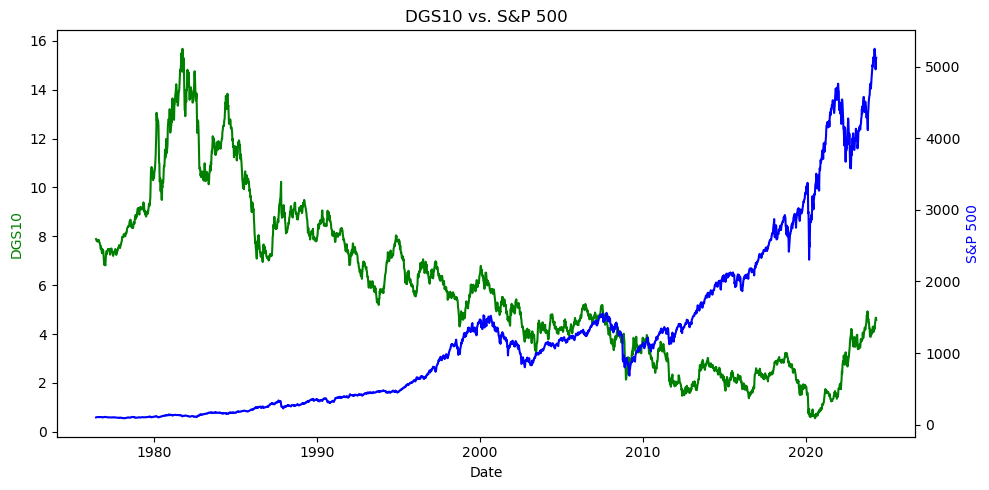

In [11]:
# Compare DGS10 with S&P 500 (GSPC)
# https://www.geeksforgeeks.org/how-to-add-a-y-axis-label-to-the-secondary-y-axis-in-matplotlib/

x = friday_1976.index
y1 = friday_1976['DGS10']
y2 = friday_1976['^GSPC']

fig, ax = plt.subplots(figsize = (10, 5))
plt.title('DGS10 vs. S&P 500')
 
ax2 = ax.twinx()
ax.plot(x, y1, color = 'g')
ax2.plot(x, y2, color = 'b')
 

ax.set_xlabel('Date')
ax.set_ylabel('DGS10', color = 'g')
 
ax2.set_ylabel('S&P 500', color = 'b')
 

plt.tight_layout()
 
plt.show()

In [12]:
friday_1976.columns

Index(['ASPUS', 'CIVPART', 'CORESTICKM159SFRBATL', 'CPIAUCSL', 'CPILFESL',
       'CSUSHPINSA', 'DFF', 'DGS10', 'DGS2', 'DGS20', 'DGS3', 'DGS5', 'DGS7',
       'DTB3', 'GDP', 'GDPC1', 'GFDEBTN', 'GFDEGDQ188S', 'ICSA', 'M1SL',
       'M2SL', 'M2V', 'MORTGAGE30US', 'MSPUS', 'PAYEMS', 'PCE', 'PSAVERT',
       'UNRATE', '^GSPC', 'TermSpread', 'DGS10_13WShift', '^GSPC_13WShift',
       'DGS10_13WChange', '^GSPC_13WChange', 'ASPUS_pc', 'CPIAUCSL_pc',
       'CPILFESL_pc', 'CSUSHPINSA_pc', 'GDP_pc', 'GDPC1_pc', 'GFDEBTN_pc',
       'ICSA_pc', 'M1SL_pc', 'M2SL_pc', 'MSPUS_pc', 'PAYEMS_pc', 'PCE_pc',
       '^GSPC_pc'],
      dtype='object')

In [13]:
friday_1976 = friday_1976.dropna() # drop rows that don't have a 13WShift value yet (the first 13 weeks and most recent 13 weeks)
friday_1976.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2475 entries, 1976-09-03 to 2024-02-02
Data columns (total 48 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ASPUS                 2475 non-null   float64
 1   CIVPART               2475 non-null   float64
 2   CORESTICKM159SFRBATL  2475 non-null   float64
 3   CPIAUCSL              2475 non-null   float64
 4   CPILFESL              2475 non-null   float64
 5   CSUSHPINSA            2475 non-null   float64
 6   DFF                   2475 non-null   float64
 7   DGS10                 2475 non-null   float64
 8   DGS2                  2475 non-null   float64
 9   DGS20                 2475 non-null   float64
 10  DGS3                  2475 non-null   float64
 11  DGS5                  2475 non-null   float64
 12  DGS7                  2475 non-null   float64
 13  DTB3                  2475 non-null   float64
 14  GDP                   2475 non-null   float64
 15  GDP

In [14]:
# Correlations using only unique value rows for each feature

correlations_list = {}
for column in friday_1976.columns:
    
    if column == 'DGS10_13WChange':
        pass
    else:
        # Create a boolean mask to identify rows where column value is different from the previous row
        mask = friday_1976[column] != friday_1976[column].shift()

        # Filter the DataFrame to keep only rows where the mask is True
        filtered_df = friday_1976[mask]
    
        correlation = filtered_df[['DGS10_13WChange',column]].corr()
        correlations_list[column]=correlation[column]['DGS10_13WChange']

correlations_list

{'ASPUS': 0.04195626015577821,
 'CIVPART': -0.08758022226697068,
 'CORESTICKM159SFRBATL': 0.09976542506560461,
 'CPIAUCSL': 0.005649180263369805,
 'CPILFESL': -0.0039328442164509834,
 'CSUSHPINSA': 0.03589752409403138,
 'DFF': 0.0030985510292084314,
 'DGS10': -0.10089794855743271,
 'DGS2': -0.07203509883447162,
 'DGS20': -0.09134734727109964,
 'DGS3': -0.0761225632070806,
 'DGS5': -0.08698145671869383,
 'DGS7': -0.1006094487237201,
 'DTB3': -0.03125138311226769,
 'GDP': 0.046292534496435764,
 'GDPC1': 0.04614000122545027,
 'GFDEBTN': 0.06842612096266476,
 'GFDEGDQ188S': 0.05659199094067988,
 'ICSA': -0.004173767748773154,
 'M1SL': 0.10929215412229033,
 'M2SL': 0.06493368269306178,
 'M2V': -0.10470501454248211,
 'MORTGAGE30US': -0.12255403811636005,
 'MSPUS': 0.06770320063496464,
 'PAYEMS': 0.003869038579486754,
 'PCE': 0.02405898065039028,
 'PSAVERT': 0.0035119601495543448,
 'UNRATE': -0.023639667499496215,
 '^GSPC': 0.06029974381591385,
 'TermSpread': -0.04962397274694067,
 'DGS10_13W

In [15]:
# To see some percentile thresholds for the 13-week change in DGS10

friday_1976['DGS10_13WChange'].quantile([0.1,0.15,0.2,0.25,0.5,0.75,0.8,0.85,0.9])

0.10   -0.720
0.15   -0.560
0.20   -0.450
0.25   -0.350
0.50    0.000
0.75    0.320
0.80    0.410
0.85    0.520
0.90    0.676
Name: DGS10_13WChange, dtype: float64

In [16]:
# Create ranges for change in 13-week change in DGS10:

def DGS10_ranges(row):
    if row <= -0.5:
        return '<=-0.5'
    elif -0.5< row < 0.5:
        return 'between -0.5 and 0.5'
    else:
        return '>=0.5'


friday_1976['DGS10_change_range'] = friday_1976['DGS10_13WChange'].apply(DGS10_ranges)
friday_1976.tail()

,ASPUS,CIVPART,CORESTICKM159SFRBATL,CPIAUCSL,CPILFESL,CSUSHPINSA,DFF,DGS10,DGS2,DGS20,...,GDPC1_pc,GFDEBTN_pc,ICSA_pc,M1SL_pc,M2SL_pc,MSPUS_pc,PAYEMS_pc,PCE_pc,^GSPC_pc,DGS10_change_range
model_date,,,,,,,,,,,,,,,,,,,,,
2024-01-05,513400.0,62.5,4.730629,307.917,312.251,312.953,5.33,4.05,4.40,4.37,...,10.230690,2.582744,-2.415459,-1.498876,-0.469200,3.580870,0.228209,0.704868,9.022635,between -0.5 and 0.5
2024-01-12,513400.0,62.5,4.584186,308.850,313.216,312.953,5.33,3.96,4.14,4.32,...,10.230690,2.582744,-3.349282,-1.498876,-0.469200,3.580870,0.228209,0.704868,10.537743,>=0.5
2024-01-19,513400.0,62.5,4.584186,308.850,313.216,312.953,5.33,4.15,4.39,4.47,...,10.230690,2.582744,-5.555556,-1.498876,-0.469200,3.580870,0.228209,0.704868,14.574492,between -0.5 and 0.5
2024-01-26,492300.0,62.5,4.584186,308.850,313.216,312.953,5.33,4.15,4.34,4.49,...,0.806044,2.582744,1.904762,-0.385221,0.531441,-3.085847,0.228209,0.786596,18.788695,>=0.5
2024-02-02,492300.0,62.5,4.584186,308.850,313.216,312.146,5.33,4.03,4.36,4.33,...,0.806044,2.582744,3.225806,-0.385221,0.531441,-3.085847,0.495147,0.786596,13.772905,>=0.5


<Axes: xlabel='DGS10_change_range', ylabel='^GSPC_13WChange'>

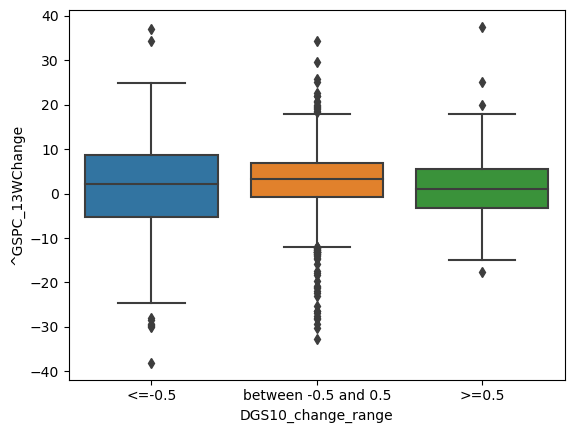

In [17]:
sns.boxplot(x='DGS10_change_range',y='^GSPC_13WChange',data=friday_1976, order=['<=-0.5','between -0.5 and 0.5','>=0.5'])

In [18]:
friday_1976['DGS10_change_range'].value_counts()

between -0.5 and 0.5    1637
<=-0.5                   439
>=0.5                    399
Name: DGS10_change_range, dtype: int64

In [19]:
# To see how the S&P 500 (GSPC) moves coincidentally to changes in DGS10

DGS10_change_comp = friday_1976.groupby('DGS10_change_range')['^GSPC_13WChange'].agg(['mean','std','min','max'])

# Calculate reward-to-risk using annualized average return and annualized volatility
DGS10_change_comp['Reward-to-risk'] = ( DGS10_change_comp['mean'] / DGS10_change_comp['std'] ) * 4**0.5

DGS10_change_comp

,mean,std,min,max,Reward-to-risk
DGS10_change_range,,,,,
<=-0.5,1.237496,10.440083,-38.087753,37.074540,0.237066
>=0.5,1.511446,6.482001,-17.662084,37.564755,0.466352
between -0.5 and 0.5,2.869152,6.723872,-32.730703,34.396860,0.853423


In [20]:
# Create class column for change in DGS10
# -1 if <=-0.5
# 0 if between -0.5 and 0.5
# 1 if >=0.5

friday_1976['DGS10_change_class'] = [0 if x=='<=-0.5' else 2 if x=='>=0.5' else 1 
                                     for x in friday_1976['DGS10_change_range']]

In [21]:
#friday_1976.to_csv('friday_data_1976.csv')

# Testing Models with GridSearchCV

In [102]:
def grid_search_test(X_train,y_train,X_test,y_test,model,param_dictionary,scoring,class_weight=None):
    
    grid_search = GridSearchCV(model,param_dictionary,cv=5,scoring=scoring)
    
    if class_weight is not None:
        grid_search.fit(X_train,y_train,sample_weight=class_weight)
    else:
        grid_search.fit(X_train,y_train)

    grid_search_best = grid_search.best_estimator_

    train_accuracy = grid_search_best.score(X_train,y_train)
    test_accuracy = grid_search_best.score(X_test, y_test)
    print(f"Train Accuracy: {train_accuracy:.2f}")
    print(f"Test Accuracy: {test_accuracy:.2f}")

    y_pred_train = grid_search_best.predict(X_train)
    y_pred_test = grid_search_best.predict(X_test)
    print(classification_report(y_train, y_pred_train))
    print(classification_report(y_test, y_pred_test))

    print(grid_search.best_params_)

In [103]:
# Logistic Regression using Grid Search CV

X = friday_1976.drop(['DGS10_13WShift','^GSPC_13WShift','DGS10_13WChange','^GSPC_13WChange',
                      'DGS10_change_range','DGS10_change_class',
                     'ASPUS','CPIAUCSL','CPILFESL','CSUSHPINSA','GDP','GDPC1','GFDEBTN',
                      'ICSA','M1SL','M2SL','MSPUS','PAYEMS','PCE','^GSPC',
                     ],axis=1)

y = friday_1976['DGS10_change_class']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



lr_gs1 = LogisticRegression(solver='saga',max_iter=3000,random_state=42)

lr_gs1_param = {'penalty': ['l1','l2','elasticnet'],
                    'C' : [0.3,0.5,1,3],
               'l1_ratio':[0.5]}


grid_search_test(X_train,y_train,X_test,y_test,lr_gs1,lr_gs1_param,'f1_macro')

Train Accuracy: 0.69
Test Accuracy: 0.69
              precision    recall  f1-score   support

           0       0.55      0.19      0.28       351
           1       0.71      0.95      0.81      1310
           2       0.57      0.18      0.28       319

    accuracy                           0.69      1980
   macro avg       0.61      0.44      0.46      1980
weighted avg       0.66      0.69      0.63      1980

              precision    recall  f1-score   support

           0       0.54      0.16      0.25        88
           1       0.70      0.97      0.81       327
           2       0.71      0.15      0.25        80

    accuracy                           0.69       495
   macro avg       0.65      0.43      0.44       495
weighted avg       0.67      0.69      0.62       495

{'C': 3, 'l1_ratio': 0.5, 'penalty': 'l1'}


In [104]:
# Random Forest using Grid Search CV

X = friday_1976.drop(['DGS10_13WShift','^GSPC_13WShift','DGS10_13WChange','^GSPC_13WChange',
                      'DGS10_change_range','DGS10_change_class',
                     'ASPUS','CPIAUCSL','CPILFESL','CSUSHPINSA','GDP','GDPC1','GFDEBTN',
                      'ICSA','M1SL','M2SL','MSPUS','PAYEMS','PCE','^GSPC',
                     ],axis=1)

y = friday_1976['DGS10_change_class']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


rf_gs1 = RandomForestClassifier(n_estimators=1000,n_jobs=-1,random_state=42)

rf_gs1_param = {'max_depth': [5,6,7],
              'min_samples_split': [10,20],
                'min_samples_leaf': [5,10],
                'max_features': [0.8,0.9]
               }

grid_search_test(X_train,y_train,X_test,y_test,rf_gs1,rf_gs1_param,'f1_macro')

Train Accuracy: 0.81
Test Accuracy: 0.77
              precision    recall  f1-score   support

           0       0.95      0.39      0.56       351
           1       0.78      0.99      0.87      1310
           2       0.94      0.52      0.67       319

    accuracy                           0.81      1980
   macro avg       0.89      0.63      0.70      1980
weighted avg       0.84      0.81      0.78      1980

              precision    recall  f1-score   support

           0       0.90      0.32      0.47        88
           1       0.75      0.98      0.85       327
           2       0.89      0.41      0.56        80

    accuracy                           0.77       495
   macro avg       0.85      0.57      0.63       495
weighted avg       0.80      0.77      0.74       495

{'max_depth': 7, 'max_features': 0.9, 'min_samples_leaf': 5, 'min_samples_split': 10}


In [105]:
# Ada Boost using Grid Search CV

X = friday_1976.drop(['DGS10_13WShift','^GSPC_13WShift','DGS10_13WChange','^GSPC_13WChange',
                      'DGS10_change_range','DGS10_change_class',
                     'ASPUS','CPIAUCSL','CPILFESL','CSUSHPINSA','GDP','GDPC1','GFDEBTN',
                      'ICSA','M1SL','M2SL','MSPUS','PAYEMS','PCE','^GSPC',
                     ],axis=1)

y = friday_1976['DGS10_change_class']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


ada_gs1 = AdaBoostClassifier(n_estimators=1000,random_state=42)

ada_gs1_param = {'learning_rate': [0.01,0.05,0.1,0.3,0.5],
              'algorithm': ['SAMME','SAMME.R'],
               }

grid_search_test(X_train,y_train,X_test,y_test,ada_gs1,ada_gs1_param,'f1_macro')

Train Accuracy: 0.71
Test Accuracy: 0.65
              precision    recall  f1-score   support

           0       0.61      0.58      0.60       351
           1       0.78      0.77      0.78      1310
           2       0.52      0.56      0.54       319

    accuracy                           0.71      1980
   macro avg       0.64      0.64      0.64      1980
weighted avg       0.71      0.71      0.71      1980

              precision    recall  f1-score   support

           0       0.50      0.48      0.49        88
           1       0.74      0.73      0.74       327
           2       0.46      0.49      0.47        80

    accuracy                           0.65       495
   macro avg       0.57      0.57      0.57       495
weighted avg       0.65      0.65      0.65       495

{'algorithm': 'SAMME.R', 'learning_rate': 0.5}


In [49]:
# Light GBM using Grid Search CV

X = friday_1976.drop(['DGS10_13WShift','^GSPC_13WShift','DGS10_13WChange','^GSPC_13WChange',
                      'DGS10_change_range','DGS10_change_class',
                     'ASPUS','CPIAUCSL','CPILFESL','CSUSHPINSA','GDP','GDPC1','GFDEBTN',
                      'ICSA','M1SL','M2SL','MSPUS','PAYEMS','PCE','^GSPC',
                     ],axis=1)

y = friday_1976['DGS10_change_class']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


lgbm_gs1 = LGBMClassifier(n_estimators=1000,random_state=42,verbose=-1)

lgbm_gs1_param = {'num_leaves': [20,31],
              'learning_rate': [0.1,0.5],
               'max_depth': [5,6],
                'min_data_in_leaf':[5,10],
                'bagging_fraction':[0.8],
                 'feature_fraction': [0.8],
                'lambda_l1':[3,5],
                'lambda_l2':[3,5]}

grid_search_test(X_train,y_train,X_test,y_test,lgbm_gs1,lgbm_gs1_param,'f1_macro')

Train Accuracy: 0.97
Test Accuracy: 0.85
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       351
           1       0.97      0.99      0.98      1310
           2       0.98      0.94      0.96       319

    accuracy                           0.97      1980
   macro avg       0.98      0.95      0.97      1980
weighted avg       0.97      0.97      0.97      1980

              precision    recall  f1-score   support

           0       0.81      0.69      0.75        88
           1       0.85      0.93      0.89       327
           2       0.87      0.69      0.77        80

    accuracy                           0.85       495
   macro avg       0.85      0.77      0.80       495
weighted avg       0.85      0.85      0.85       495

{'bagging_fraction': 0.8, 'feature_fraction': 0.8, 'lambda_l1': 3, 'lambda_l2': 5, 'learning_rate': 0.5, 'max_depth': 6, 'min_data_in_leaf': 5, 'num_leaves': 31}


In [30]:
# XG Boost using Grid Search CV

X = friday_1976.drop(['DGS10_13WShift','^GSPC_13WShift','DGS10_13WChange','^GSPC_13WChange',
                      'DGS10_change_range','DGS10_change_class',
                     'ASPUS','CPIAUCSL','CPILFESL','CSUSHPINSA','GDP','GDPC1','GFDEBTN',
                      'ICSA','M1SL','M2SL','MSPUS','PAYEMS','PCE','^GSPC',
                     ],axis=1)

y = friday_1976['DGS10_change_class']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


xgb_gs1 = XGBClassifier(n_estimators=1000,random_state=42)

xgb_gs1_param = {'max_depth': [5,6],
              'learning_rate': [0.1,0.5],
               'min_child_weight': [20,30],
                'min_split_loss':[0.2,0.3],
                'subsample':[0.8],
                 'colsample_bytree': [0.8],
                'reg_alpha':[3,5],
                'reg_lambda':[3,5]}

grid_search_test(X_train,y_train,X_test,y_test,xgb_gs1,xgb_gs1_param,'f1_macro')

Train Accuracy: 0.97
Test Accuracy: 0.84
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       351
           1       0.97      0.99      0.98      1310
           2       0.98      0.92      0.95       319

    accuracy                           0.97      1980
   macro avg       0.97      0.95      0.96      1980
weighted avg       0.97      0.97      0.97      1980

              precision    recall  f1-score   support

           0       0.87      0.67      0.76        88
           1       0.83      0.94      0.89       327
           2       0.84      0.59      0.69        80

    accuracy                           0.84       495
   macro avg       0.85      0.73      0.78       495
weighted avg       0.84      0.84      0.83       495

{'colsample_bytree': 0.8, 'learning_rate': 0.5, 'max_depth': 6, 'min_child_weight': 20, 'min_split_loss': 0.2, 'reg_alpha': 3, 'reg_lambda': 3, 'subsample': 0.8}


# Testing impact of using Class Weights

In [52]:
# Light GBM using best parameters but with balanced class weights 

X = friday_1976.drop(['DGS10_13WShift','^GSPC_13WShift','DGS10_13WChange','^GSPC_13WChange',
                      'DGS10_change_range','DGS10_change_class',
                     'ASPUS','CPIAUCSL','CPILFESL','CSUSHPINSA','GDP','GDPC1','GFDEBTN',
                      'ICSA','M1SL','M2SL','MSPUS','PAYEMS','PCE','^GSPC',
                     ],axis=1)

y = friday_1976['DGS10_change_class']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


classes_weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)

lgbm_gs2 = LGBMClassifier(n_estimators=1000,random_state=42,verbose=-1)

lgbm_gs2_param = {'num_leaves': [31],
              'learning_rate': [0.5],
               'max_depth': [6],
                'min_data_in_leaf':[5],
                'bagging_fraction':[0.8],
                 'feature_fraction': [0.8],
                'lambda_l1':[3],
                'lambda_l2':[5]}

grid_search_test(X_train,y_train,X_test,y_test,lgbm_gs2,lgbm_gs2_param,'f1_macro',classes_weights)

Train Accuracy: 0.95
Test Accuracy: 0.85
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       351
           1       1.00      0.93      0.96      1310
           2       0.87      1.00      0.93       319

    accuracy                           0.95      1980
   macro avg       0.92      0.98      0.94      1980
weighted avg       0.96      0.95      0.95      1980

              precision    recall  f1-score   support

           0       0.77      0.81      0.79        88
           1       0.89      0.90      0.89       327
           2       0.82      0.74      0.78        80

    accuracy                           0.85       495
   macro avg       0.83      0.81      0.82       495
weighted avg       0.85      0.85      0.85       495

{'bagging_fraction': 0.8, 'feature_fraction': 0.8, 'lambda_l1': 3, 'lambda_l2': 5, 'learning_rate': 0.5, 'max_depth': 6, 'min_data_in_leaf': 5, 'num_leaves': 31}


In [53]:
# XG Boost using best parameters but with balanced class weights 

X = friday_1976.drop(['DGS10_13WShift','^GSPC_13WShift','DGS10_13WChange','^GSPC_13WChange',
                      'DGS10_change_range','DGS10_change_class',
                     'ASPUS','CPIAUCSL','CPILFESL','CSUSHPINSA','GDP','GDPC1','GFDEBTN',
                      'ICSA','M1SL','M2SL','MSPUS','PAYEMS','PCE','^GSPC',
                     ],axis=1)

y = friday_1976['DGS10_change_class']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


classes_weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)


xgb_gs2 = XGBClassifier(n_estimators=1000,random_state=42)

xgb_gs2_param = {'max_depth': [6],
              'learning_rate': [0.5],
               'min_child_weight': [20],
                'min_split_loss':[0.2],
                'subsample':[0.8],
                 'colsample_bytree': [0.8],
                'reg_alpha':[3],
                'reg_lambda':[3]}

grid_search_test(X_train,y_train,X_test,y_test,xgb_gs2,xgb_gs2_param,'f1_macro',classes_weights)

Train Accuracy: 0.94
Test Accuracy: 0.86
              precision    recall  f1-score   support

           0       0.86      1.00      0.92       351
           1       1.00      0.91      0.95      1310
           2       0.84      1.00      0.91       319

    accuracy                           0.94      1980
   macro avg       0.90      0.97      0.93      1980
weighted avg       0.95      0.94      0.94      1980

              precision    recall  f1-score   support

           0       0.79      0.82      0.80        88
           1       0.90      0.88      0.89       327
           2       0.76      0.80      0.78        80

    accuracy                           0.86       495
   macro avg       0.82      0.83      0.83       495
weighted avg       0.86      0.86      0.86       495

{'colsample_bytree': 0.8, 'learning_rate': 0.5, 'max_depth': 6, 'min_child_weight': 20, 'min_split_loss': 0.2, 'reg_alpha': 3, 'reg_lambda': 3, 'subsample': 0.8}


# Reducing features from XGBoost Model

Train Accuracy: 0.94
Test Accuracy: 0.86
              precision    recall  f1-score   support

           0       0.86      1.00      0.92       351
           1       1.00      0.91      0.95      1310
           2       0.84      1.00      0.91       319

    accuracy                           0.94      1980
   macro avg       0.90      0.97      0.93      1980
weighted avg       0.95      0.94      0.94      1980

              precision    recall  f1-score   support

           0       0.79      0.82      0.80        88
           1       0.90      0.88      0.89       327
           2       0.76      0.80      0.78        80

    accuracy                           0.86       495
   macro avg       0.82      0.83      0.83       495
weighted avg       0.86      0.86      0.86       495



<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

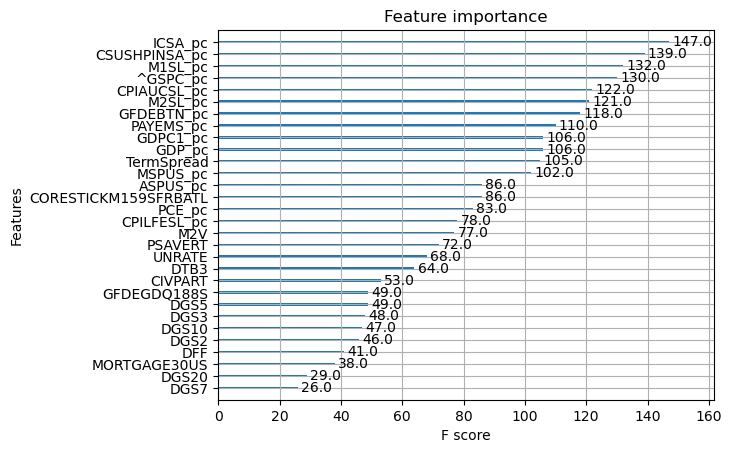

In [55]:
# XG Boost model with all features 

X = friday_1976.drop(['DGS10_13WShift','^GSPC_13WShift','DGS10_13WChange','^GSPC_13WChange',
                      'DGS10_change_range','DGS10_change_class',
                     'ASPUS','CPIAUCSL','CPILFESL','CSUSHPINSA','GDP','GDPC1','GFDEBTN',
                      'ICSA','M1SL','M2SL','MSPUS','PAYEMS','PCE','^GSPC',
                     ],axis=1)

y = friday_1976['DGS10_change_class']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


classes_weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)

xgb_all = XGBClassifier(n_estimators=1000,n_jobs=-1,max_depth=6,learning_rate=0.5,random_state=42,
                    min_child_weight=20, min_split_loss=0.2, reg_alpha=3, reg_lambda=3,
                    subsample=0.8, colsample_bytree=0.8)

xgb_all.fit(X_train,y_train, sample_weight=classes_weights)

train_accuracy = xgb_all.score(X_train,y_train)
test_accuracy = xgb_all.score(X_test, y_test)
print(f"Train Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

y_pred_train = xgb_all.predict(X_train)
y_pred_test = xgb_all.predict(X_test)
print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))


# retrieving feature names and plotting feature importance

feature_dict={}
feature_list=[]
for i in range(len(X.columns)):
    string='f'+str(i)
    feature_dict[string]=X.columns[i]
    feature_list.append(X.columns[i])

xgb_all.get_booster().feature_names = feature_list
xgb.plot_importance(xgb_all.get_booster(),max_num_features=30)

Train Accuracy: 0.90
Test Accuracy: 0.84
              precision    recall  f1-score   support

           0       0.80      0.97      0.88       351
           1       0.98      0.87      0.92      1310
           2       0.79      0.97      0.87       319

    accuracy                           0.90      1980
   macro avg       0.86      0.94      0.89      1980
weighted avg       0.92      0.90      0.91      1980

              precision    recall  f1-score   support

           0       0.72      0.80      0.76        88
           1       0.89      0.86      0.88       327
           2       0.78      0.80      0.79        80

    accuracy                           0.84       495
   macro avg       0.80      0.82      0.81       495
weighted avg       0.84      0.84      0.84       495



<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

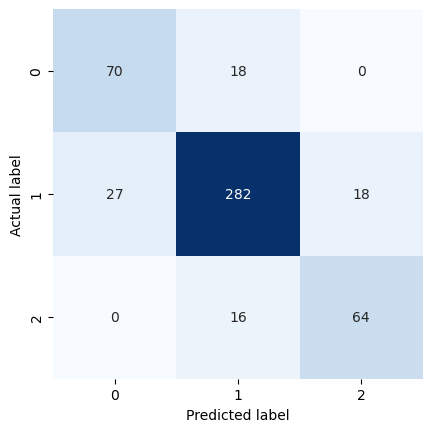

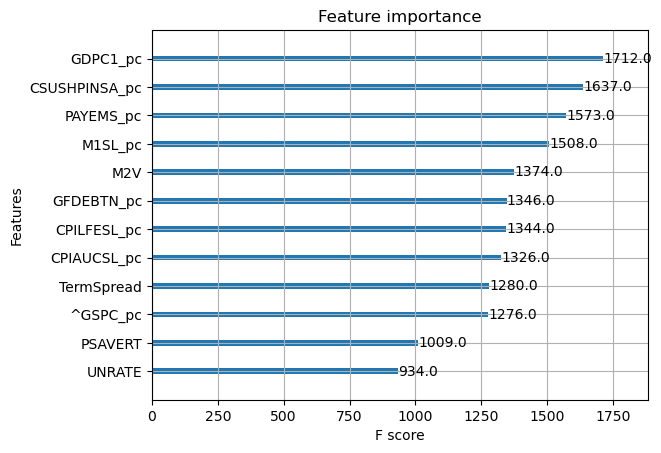

In [25]:
# Final Model (XGBoost with class weights and only 12 features)

X = friday_1976[['M2V','PSAVERT','UNRATE','CPIAUCSL_pc','CPILFESL_pc','CSUSHPINSA_pc',
                'GDPC1_pc','GFDEBTN_pc','M1SL_pc','PAYEMS_pc','^GSPC_pc','TermSpread']]

y = friday_1976['DGS10_change_class']


# X_train_pre and X_test_pre are used as variable names so that the predictions can be added back to the 
# original dataframes before any scaling
X_train_pre, X_test_pre, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_pre)
X_test = scaler.transform(X_test_pre)


classes_weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)

xgb_final = XGBClassifier(n_estimators=1000,n_jobs=-1,max_depth=6,learning_rate=0.05,random_state=42,
                    min_child_weight=20, min_split_loss=0.2, reg_alpha=3, reg_lambda=3,
                    subsample=0.8, colsample_bytree=0.8)

xgb_final.fit(X_train,y_train, sample_weight=classes_weights)

train_accuracy = xgb_final.score(X_train,y_train)
test_accuracy = xgb_final.score(X_test, y_test)
print(f"Train Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

y_pred_train = xgb_final.predict(X_train)
y_pred_test = xgb_final.predict(X_test)
print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

# confusion matrix:
mat = confusion_matrix(y_test, y_pred_test)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('Actual label')


# retrieving feature names and plotting feature importance:

feature_dict={}
feature_list=[]
for i in range(len(X.columns)):
    string='f'+str(i)
    feature_dict[string]=X.columns[i]
    feature_list.append(X.columns[i])

xgb_final.get_booster().feature_names = feature_list
xgb.plot_importance(xgb_final.get_booster())

### Note: in the reduced model, a smaller learning rate was used to achieve less overfitting between train and test results.

# Analysis of Incorrect Predictions in Test set from Final Model

In [26]:
# Creating prediction and true label columns
X_test_pre['pred'] = y_pred_test
X_test_pre['true'] = y_test

# Creating dataframe to compare predicted and actual labels with actual change value
comp_pred_df = X_test_pre.merge(friday_1976['DGS10_13WChange'],how='left',left_on=X_test_pre.index,right_on=friday_1976.index)
comp_pred_df

,key_0,M2V,PSAVERT,UNRATE,CPIAUCSL_pc,CPILFESL_pc,CSUSHPINSA_pc,GDPC1_pc,GFDEBTN_pc,M1SL_pc,PAYEMS_pc,^GSPC_pc,TermSpread,pred,true,DGS10_13WChange
0,1995-09-01,2.083,4.6,5.6,0.592495,0.684932,1.248439,0.102345,1.332583,-0.400104,0.523263,5.883461,0.44,0,0,-0.51
1,2010-09-10,1.705,5.9,9.6,0.008273,0.411291,2.855352,-0.288200,3.356023,0.779967,-0.198361,1.644382,2.23,1,2,0.51
2,1985-10-04,1.743,6.1,7.1,0.591716,0.919118,2.222222,0.781657,3.735771,4.213242,0.665873,-4.830668,1.52,0,0,-1.31
3,2007-11-02,1.924,0.9,4.7,0.244485,0.607311,-0.907042,1.067093,0.203533,0.337268,0.216475,5.344505,0.65,1,0,-0.69
4,1993-09-24,1.928,4.2,6.7,0.346260,0.657895,1.479251,0.127666,2.868874,2.595334,0.257296,2.240840,1.52,1,1,0.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,1981-07-31,1.853,8.3,7.3,1.807910,2.546296,2.663230,0.942628,3.689597,1.612903,-0.140761,-1.356241,-1.17,2,1,-0.04
491,1980-06-20,1.825,8.3,7.8,3.246206,3.354839,1.896831,0.424684,2.250039,-1.196538,-0.444170,11.484704,1.06,2,2,1.84
492,1993-04-09,1.893,4.1,7.0,1.055595,0.937082,-0.274116,1.122957,2.765030,1.354003,0.459015,2.981007,2.12,1,1,-0.21
493,1994-10-21,2.017,3.9,5.9,0.877785,0.638162,1.727642,0.954554,1.528300,0.505667,0.687373,2.599817,1.01,1,1,0.01


In [27]:
# Filtering dataframe to only include incorrect prediction rows
wrong_pred_df = comp_pred_df[comp_pred_df['pred']!=comp_pred_df['true']]
wrong_pred_df

,key_0,M2V,PSAVERT,UNRATE,CPIAUCSL_pc,CPILFESL_pc,CSUSHPINSA_pc,GDPC1_pc,GFDEBTN_pc,M1SL_pc,PAYEMS_pc,^GSPC_pc,TermSpread,pred,true,DGS10_13WChange
1,2010-09-10,1.705,5.9,9.6,0.008273,0.411291,2.855352,-0.288200,3.356023,0.779967,-0.198361,1.644382,2.23,1,2,0.51
3,2007-11-02,1.924,0.9,4.7,0.244485,0.607311,-0.907042,1.067093,0.203533,0.337268,0.216475,5.344505,0.65,1,0,-0.69
9,2000-12-08,2.082,-0.8,4.0,0.694847,0.715859,2.164791,0.788501,-1.514777,-0.416855,0.306485,-8.337905,-0.15,0,1,-0.40
40,2006-06-23,1.956,-1.6,4.6,1.406328,0.933661,1.465690,1.316598,2.456950,1.403841,0.235182,-4.485971,-0.04,1,0,-0.63
42,2015-03-27,1.531,5.5,5.5,-0.778798,0.382314,-0.400024,0.996867,1.780586,4.749720,0.771895,-1.328533,1.37,1,2,0.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460,2004-06-04,1.899,2.4,5.6,0.968784,0.823045,3.186994,1.052175,3.164291,3.210510,0.822878,-2.970108,2.08,0,1,-0.48
465,1981-10-16,1.853,9.1,7.5,3.218646,3.611738,1.875263,-0.417044,0.688729,0.770308,0.392281,-8.848266,-0.52,0,1,-0.12
467,2019-06-14,1.458,6.2,3.6,0.806754,0.399634,0.425124,0.679779,2.378791,0.864500,0.324688,2.285224,0.25,0,1,-0.19
488,2012-03-09,1.594,4.6,8.3,0.327214,0.547597,-3.559709,0.521239,2.924882,3.694398,0.750904,9.216139,1.71,0,1,-0.39


## Analyzing observations when incorrect prediction label = 0 (change is less than -0.5):

In [33]:
wrong_pred_df[wrong_pred_df['pred']==0]['DGS10_13WChange'].describe()

count    27.000000
mean     -0.277407
std       0.170036
min      -0.480000
25%      -0.405000
50%      -0.320000
75%      -0.140000
max       0.100000
Name: DGS10_13WChange, dtype: float64

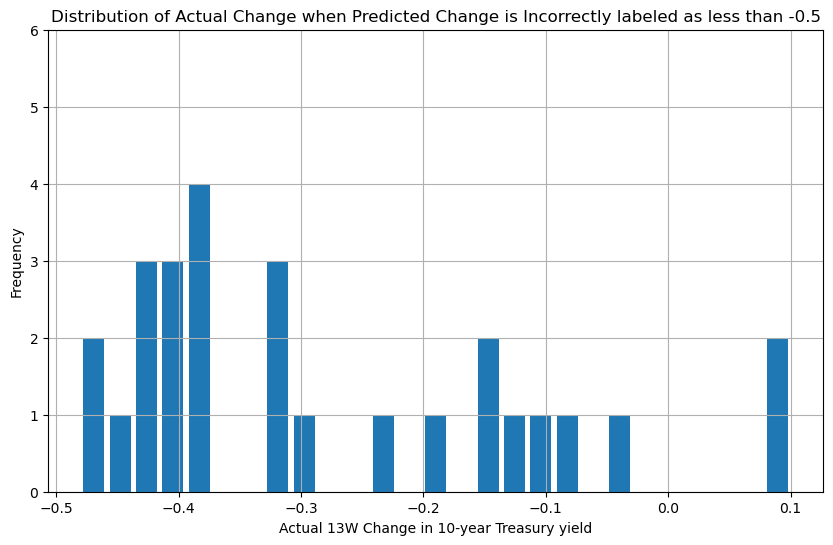

In [34]:
plt.figure(figsize=(10, 6))
wrong_pred_df[wrong_pred_df['pred']==0]['DGS10_13WChange'].hist(bins=27, rwidth=0.8)

plt.yticks(np.arange(7, step=1))

plt.xlabel('Actual 13W Change in 10-year Treasury yield')
plt.ylabel('Frequency')
plt.title('Distribution of Actual Change when Predicted Change is Incorrectly labeled as less than -0.5')


plt.show()

## Analyzing observations when incorrect prediction label = 1 (change is between -0.5 and 0.5):

In [35]:
wrong_pred_df[wrong_pred_df['pred']==1]['DGS10_13WChange'].describe()

count    34.000000
mean     -0.051765
std       0.767228
min      -1.620000
25%      -0.637500
50%      -0.515000
75%       0.537500
max       1.870000
Name: DGS10_13WChange, dtype: float64

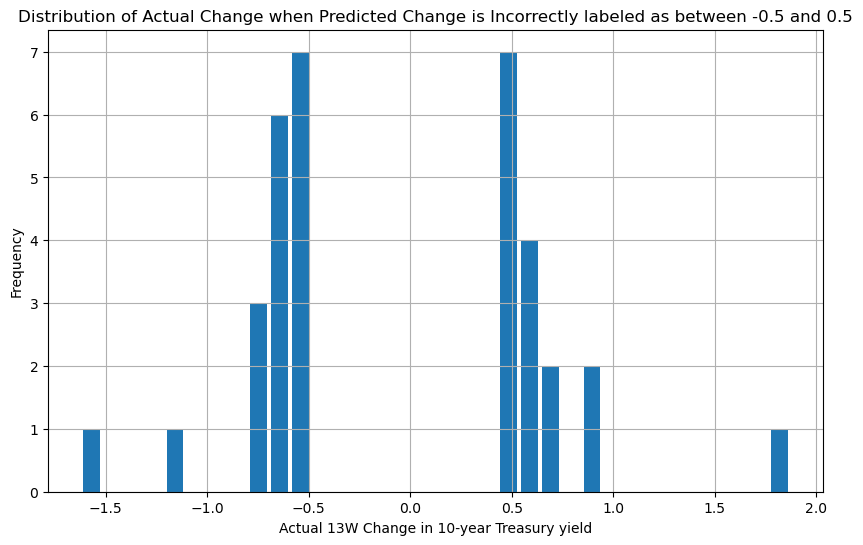

In [36]:
plt.figure(figsize=(10, 6))
wrong_pred_df[wrong_pred_df['pred']==1]['DGS10_13WChange'].hist(bins=34, rwidth=0.8)

plt.yticks(np.arange(8, step=1))

plt.xlabel('Actual 13W Change in 10-year Treasury yield')
plt.ylabel('Frequency')
plt.title('Distribution of Actual Change when Predicted Change is Incorrectly labeled as between -0.5 and 0.5')


plt.show()

## Analyzing observations when incorrect prediction label = 2 (change is more than 0.5):

In [37]:
wrong_pred_df[wrong_pred_df['pred']==2]['DGS10_13WChange'].describe()

count    18.000000
mean      0.312778
std       0.165629
min      -0.040000
25%       0.195000
50%       0.350000
75%       0.457500
max       0.490000
Name: DGS10_13WChange, dtype: float64

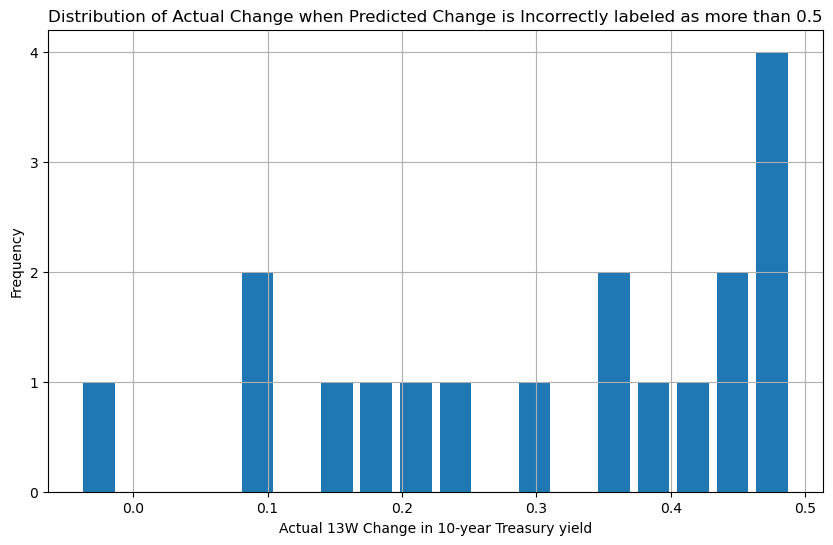

In [38]:
plt.figure(figsize=(10, 6))
wrong_pred_df[wrong_pred_df['pred']==2]['DGS10_13WChange'].hist(bins=18, rwidth=0.8)

plt.yticks(np.arange(5, step=1))

plt.xlabel('Actual 13W Change in 10-year Treasury yield')
plt.ylabel('Frequency')
plt.title('Distribution of Actual Change when Predicted Change is Incorrectly labeled as more than 0.5')


plt.show()

# Saving Final Model

In [39]:
#data = {"model":xgb_final, "scaler": scaler}
#with open('xgb_final_model.pkl','wb') as file:
#    pickle.dump(data,file)